# MD-DTW Analysis Framework  for b9d2 analysis

## Setup: Configure Environment and Import Functions

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Setup repository root
morphseq_root = os.environ.get('MORPHSEQ_REPO_ROOT')
print(f"MORPHSEQ_REPO_ROOT: {morphseq_root}")

# Change to repository root for proper imports
os.chdir(morphseq_root)
sys.path.insert(0, morphseq_root)

# Import MD-DTW analysis tools
from src.analyze.trajectory_analysis import (
    # Step 2: Array preparation
    prepare_multivariate_array,
    
    
    # Step 3: Distance computation
    compute_md_dtw_distance_matrix,
    
    # Step 4: Outlier detection
    identify_outliers,
    remove_outliers_from_distance_matrix,
    
    # Step 5: Clustering & visualization (NEW API)
    generate_dendrograms,
    add_cluster_column,
    run_bootstrap_hierarchical,
    analyze_bootstrap_results,
    plot_multimetric_trajectories,
    PASTEL_COLORS,
)


from src.analyze.trajectory_analysis import plot_dendrogram_with_categories

# For loading data
from src.analyze.trajectory_analysis import extract_trajectories_df

print("✓ Imports successful!")

MORPHSEQ_REPO_ROOT: /net/trapnell/vol1/home/mdcolon/proj/morphseq
✓ Imports successful!


## Step 1: Load and Filter Data

Load your trajectory data as a long-format DataFrame with columns:
- `embryo_id`: Unique identifier for each embryo
- `predicted_stage_hpf`: Time in hours post fertilization
- Metric columns (e.g., `baseline_deviation_normalized`, `total_length_um`, etc.)
- Optional: `genotype`, `pair`, or other categorical columns for visualization

In [2]:
# Example: Load your data
# Replace this with your actual data loading code

# Option 1: Load from CSV
# df = pd.read_csv('path/to/your/data.csv')

#Option 2: Use existing data loading utilities

from src.analyze.trajectory_analysis.data_loading import load_experiment_dataframe
# List all experiments you want to analyze together
experiment_ids = ['20251119','20251121', '20251104', '20251125']  # Add your experiment IDs

# Load and combine
dfs = []
for exp_id in experiment_ids:
    df_exp = load_experiment_dataframe(exp_id, format_version='df03')
    df_exp['experiment_id'] = exp_id  # Track which experiment each row came from
    dfs.append(df_exp)
    print(f"✓ Loaded {exp_id}: {len(df_exp)} rows, {df_exp['embryo_id'].nunique()} embryos")

# Concatenate all experiments
df = pd.concat(dfs, ignore_index=True)

print(f"\n✓ Combined data: {len(df)} rows, {df['embryo_id'].nunique()} embryos")
print(f"  Experiments: {df['experiment_id'].unique()}")

  Loading curvature from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/body_axis/summary/curvature_metrics_20251119.csv
  Loading metadata from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build06_output/df03_final_output_with_latents_20251119.csv
    Curvature: 10440 rows
    Metadata: 7254 rows
    ⚠️  Column divergence detected: ['baseline_deviation_um', 'total_length_um']
    📌 Suffixing: curvature keeps original, metadata gets '_meta'
    Merged on 'snip_id': 7254 rows
    Unique snip_ids: curvature=10440, metadata=7254, merged=7254
    ⚠️  3186 snip_ids only in curvature (dropped)
✓ Loaded 20251119: 7254 rows, 30 embryos
  Loading curvature from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/body_axis/summary/curvature_metrics_20251121.csv
  Loading metadata from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build06_output/df03_final_output_with_latents_20251121

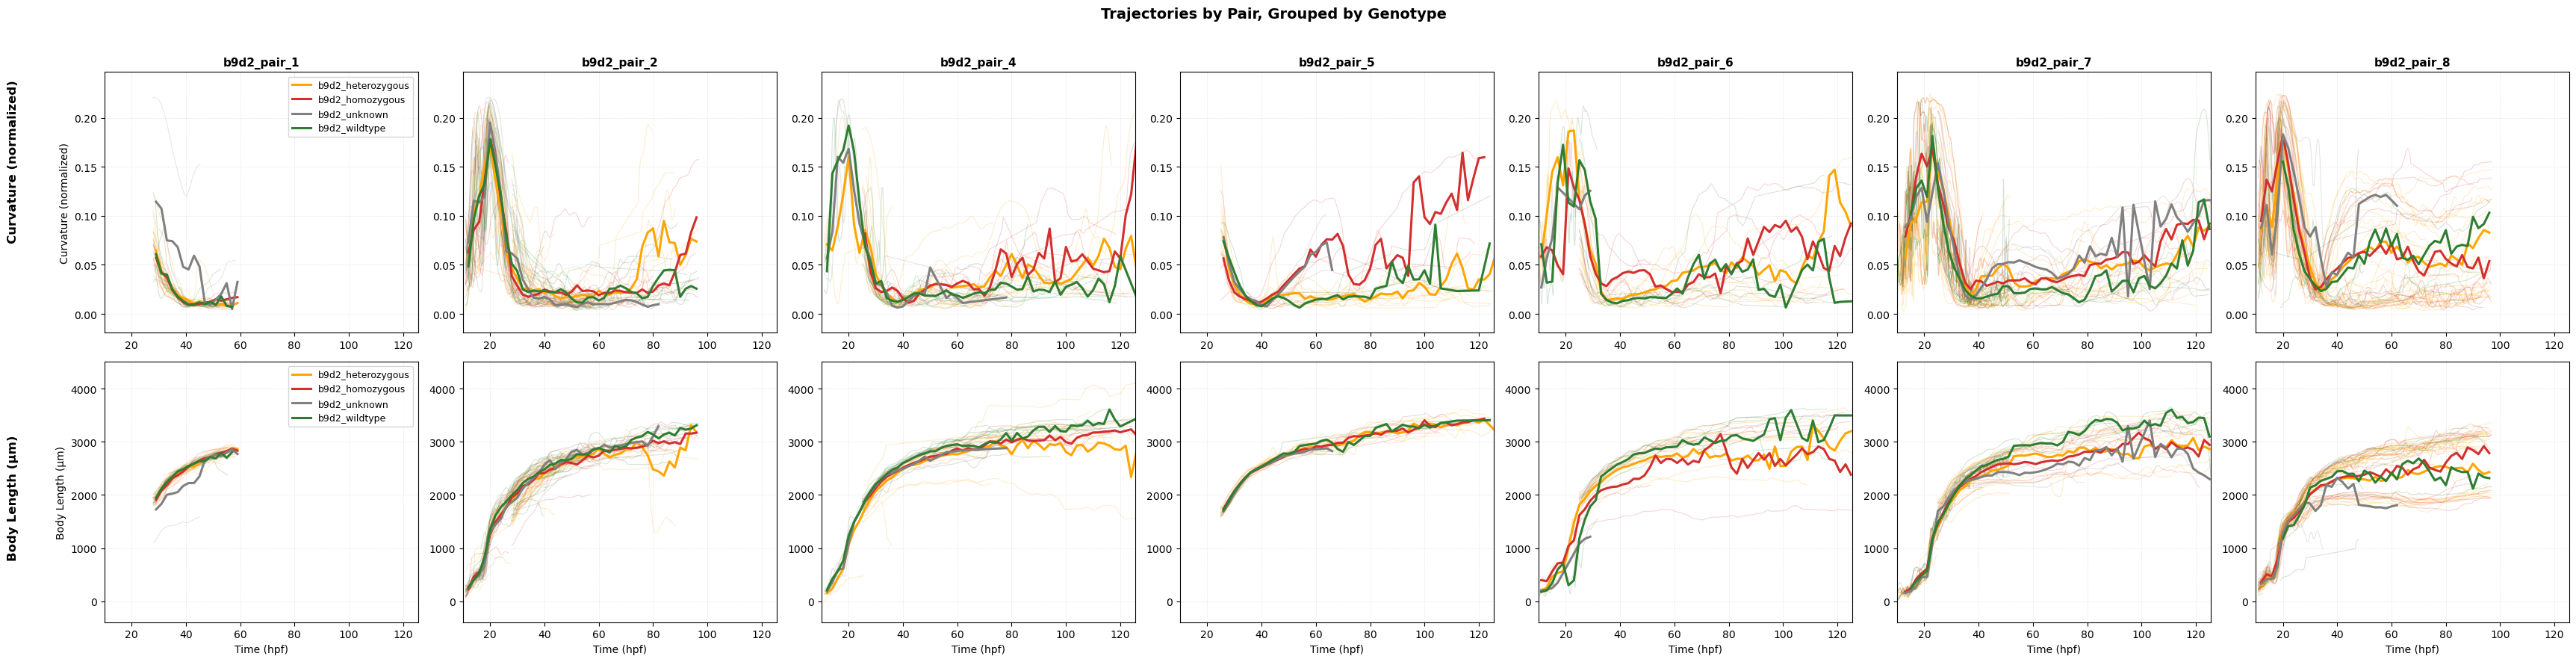

In [ ]:
 
    # Optional: Color by genotype instead to validate clusters separate genotypes
    
fig_by_genotype = plot_multimetric_trajectories(
        df,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='pair',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title='Trajectories by Pair, Grouped by Genotype',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )

### Optional: Filter by genotype or time range

You might want to filter your data before analysis:

In [3]:
# Example filters (uncomment to use)

# Filter by genotype
df_b9d2_pair_5 = df[df['pair'].isin(['b9d2_pair_5', ])].copy()

# Filter by time range
# df_filtered = df[(df['predicted_stage_hpf'] >= 24) & (df['predicted_stage_hpf'] <= 48)].copy()

# For this tutorial, use all data
df_filtered = df_b9d2_pair_5.copy()

print(f"✓ Filtered data: {df_filtered['embryo_id'].nunique()} embryos")

✓ Filtered data: 21 embryos


In [4]:
df_filtered

,snip_id,total_length_um,mean_curvature_per_um,std_curvature_per_um,max_curvature_per_um,n_centerline_points,baseline_deviation_um,max_baseline_deviation_um,baseline_deviation_std_um,arc_length_ratio,...,z_sigma_b_90,z_sigma_b_91,z_sigma_b_92,z_sigma_b_93,z_sigma_b_94,z_sigma_b_95,z_sigma_b_96,z_sigma_b_97,z_sigma_b_98,z_sigma_b_99
7471,20251121_A04_e01_t0022,2527.383089,0.000800,0.001738,0.010162,200,43.153833,83.116997,22.320753,1.017792,...,-0.020719,0.006550,0.034352,-0.030122,-0.015212,-0.020548,-0.026083,0.034834,0.017639,0.018734
7472,20251121_A04_e01_t0023,2535.636607,0.000865,0.001887,0.011052,200,34.229987,77.870130,20.889493,1.016170,...,-0.016285,0.003258,0.040655,-0.034101,-0.015769,-0.011186,-0.034228,0.041616,0.011145,0.013707
7473,20251121_A04_e01_t0024,2564.306558,0.000782,0.001322,0.006174,200,35.346769,74.816702,19.675945,1.015015,...,-0.018152,0.005950,0.043193,-0.033794,-0.012473,-0.010746,-0.029551,0.036844,0.001633,0.018701
7474,20251121_A04_e01_t0025,2573.211438,0.000749,0.001231,0.005621,200,26.053410,64.072962,16.136528,1.012588,...,-0.022571,0.006385,0.046422,-0.033812,-0.011212,-0.019570,-0.028658,0.039263,0.003181,0.012283
7475,20251121_A04_e01_t0026,2589.980498,0.000831,0.001686,0.007836,200,20.630645,76.594196,17.195742,1.018500,...,-0.017125,0.005296,0.047051,-0.035266,-0.007238,-0.030734,-0.027501,0.036395,0.004872,0.001007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15648,20251121_H05_e01_t0100,3471.691861,0.000804,0.000792,0.003942,200,50.075558,133.555588,41.730482,1.016713,...,0.002017,-0.003531,-0.059590,-0.031948,-0.105099,-0.005959,-0.021755,0.098860,0.035326,-0.005763
15649,20251121_H05_e01_t0093,3072.343207,0.000210,0.000178,0.000686,200,45.747916,88.889448,27.591455,1.004672,...,0.026950,-0.045732,-0.014492,-0.045840,-0.047436,-0.000171,0.014911,-0.011893,0.007657,0.037363
15650,20251121_H05_e01_t0095,3249.835282,0.000227,0.000161,0.000615,200,66.736760,128.867309,42.438638,1.007022,...,-0.008066,-0.031539,0.000235,-0.035535,-0.038308,0.008383,-0.002226,0.006837,0.022247,0.049863
15651,20251121_H05_e01_t0126,3221.087782,0.000110,0.000084,0.000403,200,47.596842,88.960777,30.847611,1.001951,...,-0.004938,-0.027552,-0.048446,-0.029628,-0.017704,0.012162,-0.015161,0.002381,0.048459,0.053550


## Step 2: Prepare Multivariate Array

Convert the long-format DataFrame to a 3D array suitable for MD-DTW.

**Key parameters:**
- `metrics`: List of column names to use as features (e.g., curvature + length)
- `normalize=True`: Z-score normalize each metric (recommended - ensures equal weight)
- `time_grid`: Optional pre-defined time grid (auto-computed if None)

**Output:**
- `X`: 3D array with shape (n_embryos, n_timepoints, n_metrics)
- `embryo_ids`: List of embryo IDs (same order as X rows)
- `time_grid`: Common time grid for all embryos

In [17]:
# Define which metrics to use
metrics = ['baseline_deviation_normalized', 'total_length_um']

# Prepare multivariate array
X, embryo_ids, time_grid = prepare_multivariate_array(
    df_filtered,
    metrics=metrics,
    time_col='predicted_stage_hpf',
    embryo_id_col='embryo_id',
    normalize=True,  # Z-score normalization (recommended)
    verbose=True
)

print(f"\n✓ Array prepared:")
print(f"  Shape: {X.shape} (embryos × timepoints × metrics)")
print(f"  Embryo IDs: {embryo_ids[:3]}... ({len(embryo_ids)} total)")
print(f"  Time grid: {time_grid[:3]}... ({len(time_grid)} points)")

Preparing multivariate array for 2 metrics...
  Metrics: ['baseline_deviation_normalized', 'total_length_um']
  Normalization: True
  Embryos: 21

Interpolating 2 metrics to common grid (step=0.5)
  Interpolated multi-metric shape: (3443, 5)
  Time points: 201 (25.0 - 125.0 hpf)
  Array shape: (21, 201, 2)
  Before normalization:
    baseline_deviation_normalized: mean=0.032, std=0.033
    total_length_um: mean=2793.723, std=747.640
  After normalization:
    baseline_deviation_normalized: mean=0.000000, std=1.000000
    total_length_um: mean=0.000000, std=1.000000
✓ Multivariate array prepared successfully

✓ Array prepared:
  Shape: (21, 201, 2) (embryos × timepoints × metrics)
  Embryo IDs: ['20251121_A04_e01', '20251121_A05_e01', '20251121_A06_e01']... (21 total)
  Time grid: [25.  25.5 26. ]... (201 points)


## Step 3: Compute MD-DTW Distance Matrix

Calculate pairwise multivariate DTW distances between all embryos.

**Key parameters:**
- `sakoe_chiba_radius`: Constraint on warping (default=3). Higher = more flexible alignment, slower.
- `verbose=True`: Show progress and diagnostics

**Output:**
- `D`: Symmetric distance matrix (n_embryos × n_embryos)
  - `D[i,j]` = MD-DTW distance between embryo i and j
  - Diagonal is zero (distance to self)
  - Symmetric: `D[i,j] == D[j,i]`

In [18]:
# Compute MD-DTW distance matrix
D = compute_md_dtw_distance_matrix(
    X,
    sakoe_chiba_radius=3,  # Warping constraint (3 is good default)
    verbose=True
)

print(f"\n✓ Distance matrix computed: {D.shape}")
print(f"  Distance range: [{D[D > 0].min():.3f}, {D.max():.3f}]")

Computing MD-DTW distance matrix (Pure Python/NumPy)...
  Embryos: 21
  Array shape: (21, 201, 2)
  Sakoe-Chiba radius: 3
  Processed 230/231 pairs (99%)...
✓ Distance matrix computed
  Shape: (21, 21)
  Distance range: [46.7441, 963.3687]
  Max diagonal value: 0.00e+00 (should be ~0)
  Max asymmetry: 0.00e+00 (should be ~0)

✓ Distance matrix computed: (21, 21)
  Distance range: [46.744, 963.369]


## Step 4: Outlier Detection (Optional)

Identify embryos that are consistently far from all others. These often create singleton clusters.

**Available Methods:**
- `'iqr'`: Interquartile Range method (Q3 + k×IQR) - **RECOMMENDED** for extreme outlier detection
- `'percentile'`: Flag embryos above Nth percentile of median distances (adaptive)
- `'mad'`: Median Absolute Deviation (most robust to extreme outliers)
- `'median_distance'`: Manual threshold (requires domain knowledge)

**When to use:**
- Your dendrogram shows singleton clusters
- You want to focus on the "main" phenotypic groups
- You see embryos with very high median distance

In [20]:
# Compute median distances for visualization
median_distances = np.zeros(len(embryo_ids))
for i in range(len(embryo_ids)):
    dists_to_others = np.concatenate([D[i, :i], D[i, i+1:]])
    median_distances[i] = np.median(dists_to_others)

# Test IQR method (4.0× multiplier - extreme outlier detection)
print("Testing IQR method (4.0× multiplier - extreme outlier definition)...\n")
outlier_ids_iqr, inlier_ids_iqr, outlier_info_iqr = identify_outliers(
    D,
    embryo_ids,
    method='iqr',
    threshold=4.0,  # IQR multiplier (4.0 = extreme, 1.5-3.0 = typical)
    verbose=True
)

print(f"\n✓ IQR outlier detection complete")
print(f"  Outliers: {len(outlier_ids_iqr)}")
print(f"  Inliers: {len(inlier_ids_iqr)}")

if len(outlier_ids_iqr) > 0:
    print(f"  Outlier embryos: {outlier_ids_iqr}")

Testing IQR method (4.0× multiplier - extreme outlier definition)...


Identifying outliers using 'iqr' method...
  Total embryos: 21
  Q1 (25th percentile): 105.360
  Q3 (75th percentile): 162.411
  IQR: 57.051
  IQR multiplier: 4.0×
  Threshold (Q3 + 4.0×IQR): 390.616
  Threshold: 390.616
  Outliers detected: 1
  Inliers retained: 20

  Outlier embryos:
    20251121_A05_e01: median_dist = 827.230

✓ IQR outlier detection complete
  Outliers: 1
  Inliers: 20
  Outlier embryos: ['20251121_A05_e01']


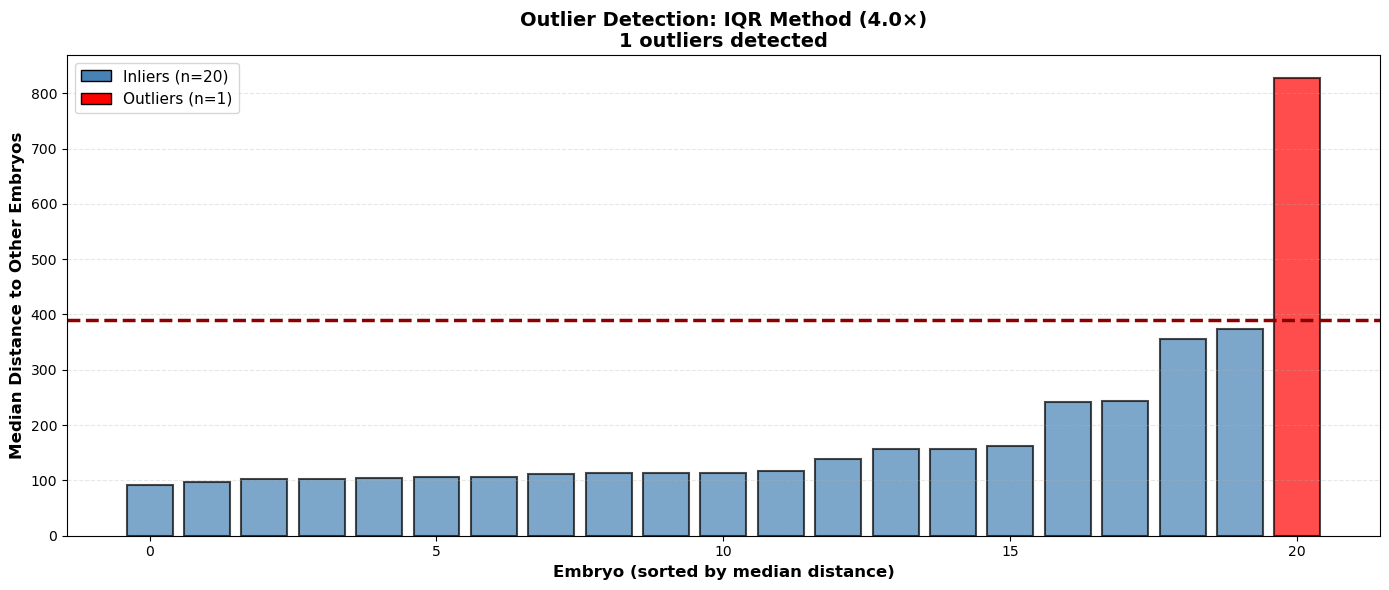

✓ Outlier visualization complete


In [22]:
# Visualize outlier detection: Bar plot with threshold
fig, ax = plt.subplots(figsize=(14, 6))

# Sort by median distance
sorted_idx = np.argsort(median_distances)
sorted_dists = median_distances[sorted_idx]
sorted_embryo_ids = [embryo_ids[i] for i in sorted_idx]

# Create outlier mask for sorted data
outlier_mask = np.array([sorted_embryo_ids[i] in outlier_ids_iqr for i in range(len(sorted_embryo_ids))])

# Plot bars
colors = ['red' if is_outlier else 'steelblue' for is_outlier in outlier_mask]
ax.bar(range(len(sorted_dists)), sorted_dists, color=colors, edgecolor='black', alpha=0.7, linewidth=1.5)

# Threshold line
threshold_iqr = outlier_info_iqr['threshold']
ax.axhline(threshold_iqr, color='darkred', linestyle='--', linewidth=2.5, label=f'IQR Threshold = {threshold_iqr:.2f}')

# Labels and formatting
ax.set_xlabel('Embryo (sorted by median distance)', fontsize=12, fontweight='bold')
ax.set_ylabel('Median Distance to Other Embryos', fontsize=12, fontweight='bold')
ax.set_title(f'Outlier Detection: IQR Method (4.0×)\n{len(outlier_ids_iqr)} outliers detected', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', label=f'Inliers (n={len(inlier_ids_iqr)})'),
    Patch(facecolor='red', edgecolor='black', label=f'Outliers (n={len(outlier_ids_iqr)})')
]
ax.legend(handles=legend_elements, fontsize=11, loc='upper left')

plt.tight_layout()
plt.show()

print(f"✓ Outlier visualization complete")

In [21]:
# Option: Remove outliers and create clean distance matrix
D_clean, embryo_ids_clean, outlier_info = remove_outliers_from_distance_matrix(
    D,
    embryo_ids,
    outlier_detection_method='iqr',
    outlier_threshold=4.0,  # IQR multiplier
    verbose=True
)

# Use cleaned data for rest of analysis
D_for_clustering = D_clean
embryo_ids_for_clustering = embryo_ids_clean

# Uncomment below to use original data (including outliers)
# D_for_clustering = D
# embryo_ids_for_clustering = embryo_ids

print(f"\n✓ Ready for clustering with {len(embryo_ids_for_clustering)} embryos")


Identifying outliers using 'iqr' method...
  Total embryos: 21
  Q1 (25th percentile): 105.360
  Q3 (75th percentile): 162.411
  IQR: 57.051
  IQR multiplier: 4.0×
  Threshold (Q3 + 4.0×IQR): 390.616
  Threshold: 390.616
  Outliers detected: 1
  Inliers retained: 20

  Outlier embryos:
    20251121_A05_e01: median_dist = 827.230

✓ Outliers removed
  Original size: (21, 21)
  Clean size: (20, 20)

✓ Ready for clustering with 20 embryos


## Step 5a: Generate Dendrograms (K Selection)

Generate hierarchical clustering dendrograms with multiple K values to select optimal K.

**Two approaches available:**

### Approach 1: Basic Dendrogram (Clean K selection)
Use `generate_dendrograms()` to create a dendrogram with K cutoff lines:
- Shows clear cluster hierarchy
- Horizontal lines indicate where to cut for each K
- No category information, pure clustering structure
- Lightweight and easy to read

### Approach 2: Dendrogram with Category Bars (Context-aware)
Use `plot_dendrogram_with_categories()` to add colored bars showing experimental metadata:
- Same dendrogram as Approach 1
- Adds color bars below for pair, genotype, or other categories
- Helps you see if clusters match experimental design
- Better for presentation and interpretation

**Recommendation:** Generate both! Compare them side-by-side to understand cluster composition.

In [23]:
# Prepare category DataFrame for dendrogram visualization
# This maps embryo IDs to their experimental metadata
category_df = df_filtered[['embryo_id', 'pair', 'genotype']].drop_duplicates().reset_index(drop=True)
print(f"✓ Category DataFrame prepared: {len(category_df)} embryos")
print(f"  Categories: pair, genotype")

✓ Category DataFrame prepared: 21 embryos
  Categories: pair, genotype


Generating dendrogram...
  Embryos: 20
  Linkage method: average
  k=2: cutoff height=293.823, cluster sizes: {0: 2, 1: 18}
  k=3: cutoff height=235.516, cluster sizes: {0: 2, 1: 17, 2: 1}
  k=4: cutoff height=221.592, cluster sizes: {0: 2, 1: 16, 2: 1, 3: 1}
  k=5: cutoff height=184.058, cluster sizes: {0: 1, 1: 1, 2: 16, 3: 1, 4: 1}
✓ Dendrogram generated


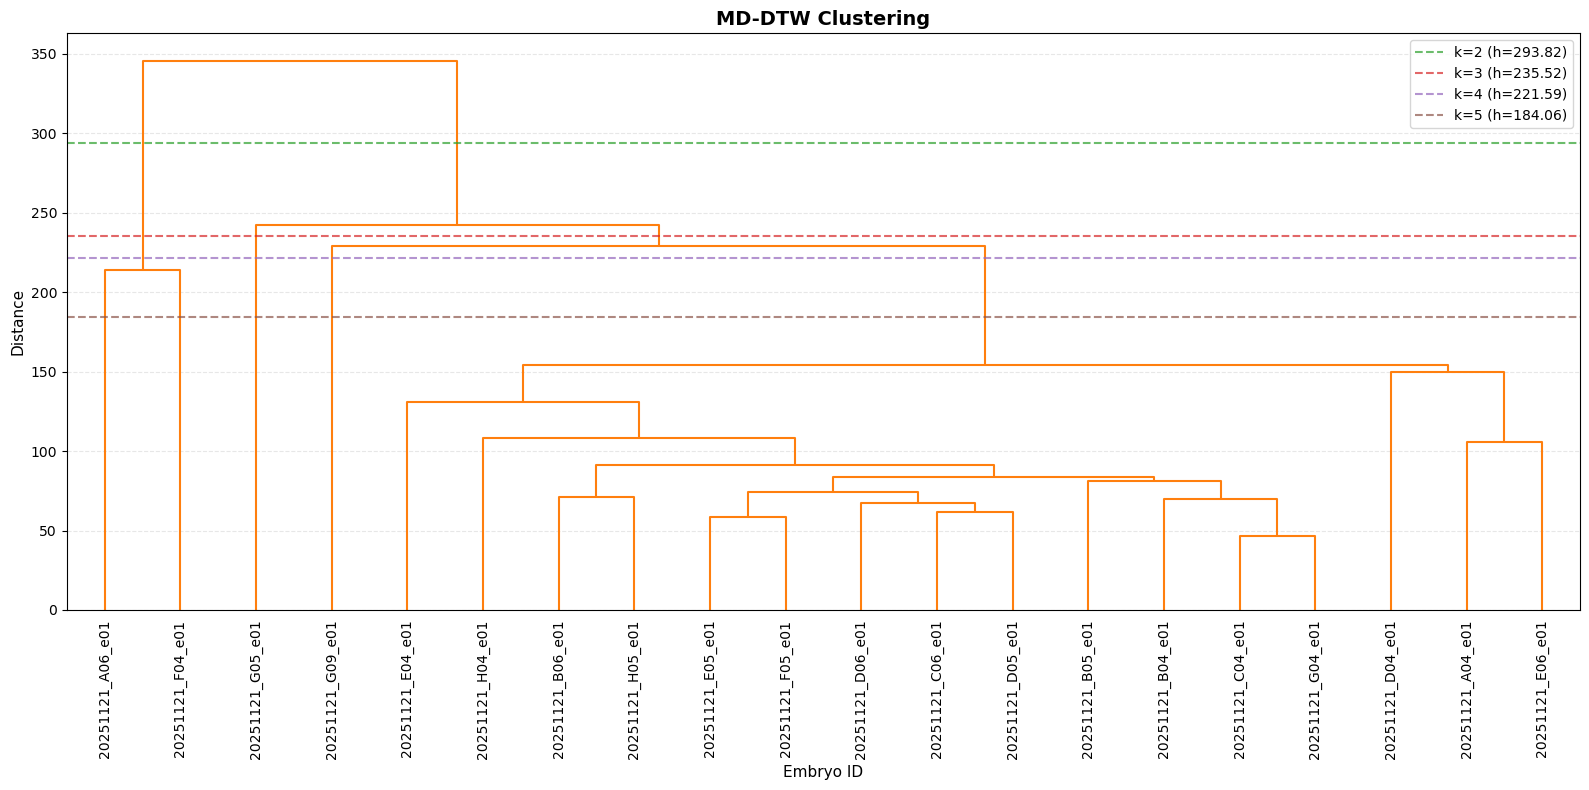

Generating dendrogram with category bars...
  Embryos: 20
  Categories: ['pair', 'genotype']
  Linkage method: average
  'pair': 1 unique values: ['b9d2_pair_5']
  'genotype': 4 unique values: ['b9d2_heterozygous', 'b9d2_homozygous', 'b9d2_unknown', 'b9d2_wildtype']
✓ Dendrogram with categories generated


/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/analyze/trajectory_analysis/dendrogram.py:672: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


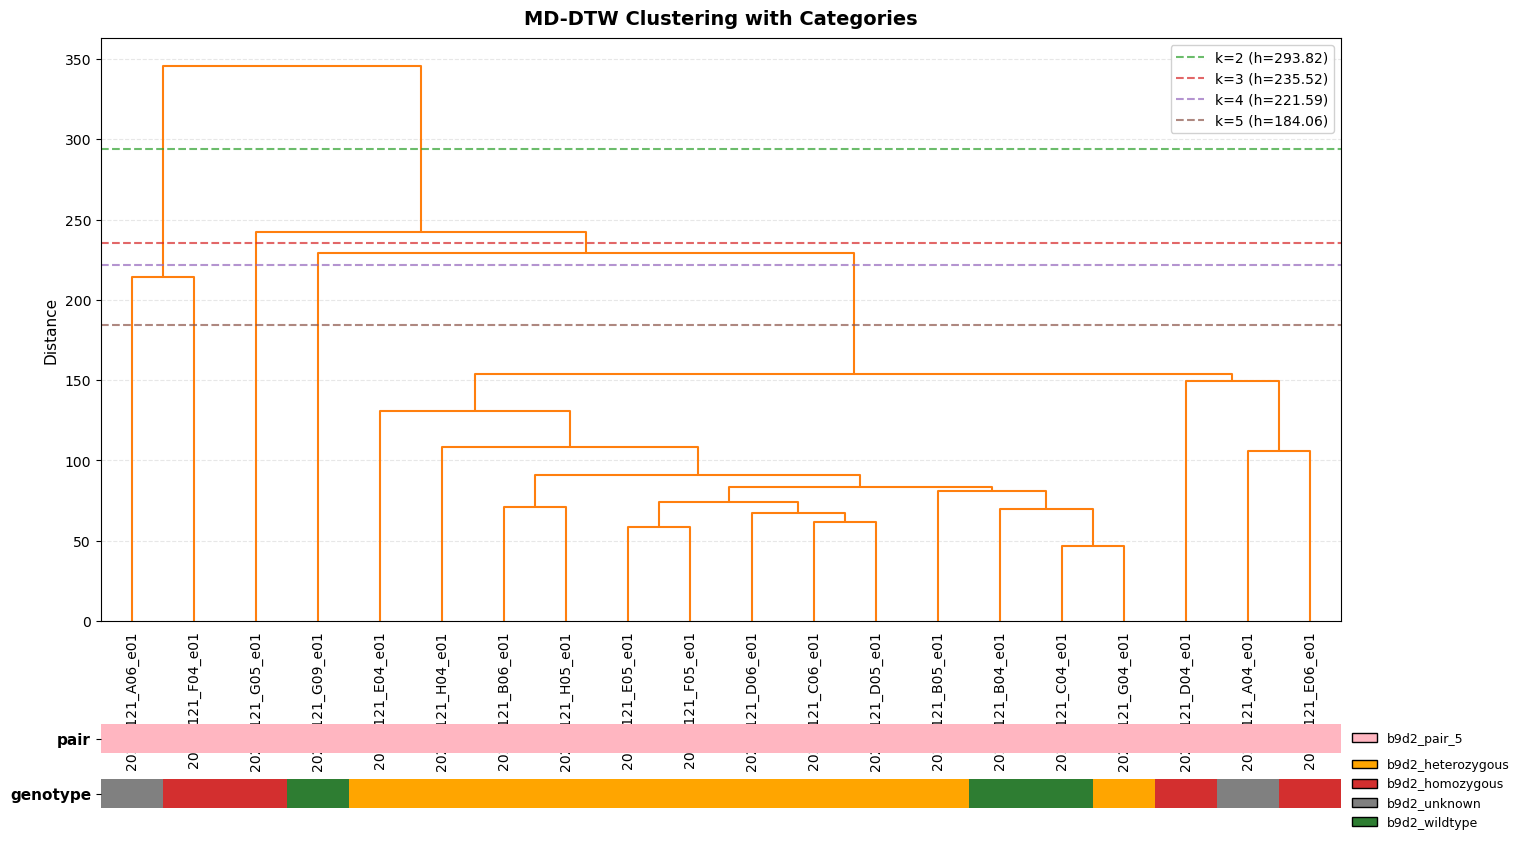


✓ Dendrograms generated successfully
  Available K values: [2, 3, 4, 5]

Cluster sizes by K:
  k=2: {0: 2, 1: 18}
  k=3: {0: 2, 1: 17, 2: 1}
  k=4: {0: 2, 1: 16, 2: 1, 3: 1}
  k=5: {0: 1, 1: 1, 2: 16, 3: 1, 4: 1}


In [ ]:
# ============================================================================
# OPTION 1: Generate basic dendrogram
# ============================================================================

# Generate basic dendrogram with K cutoff lines
fig_basic, dendro_info = generate_dendrograms(
    D_for_clustering,
    embryo_ids_for_clustering,
    k_highlight=[2, 3, 4, 5],  # K values to show as cutoff lines
    linkage_method='average',
    title='MD-DTW Clustering',
    figsize=(16, 8),
    verbose=True
)
plt.show()

# ============================================================================
# OPTION 2: Generate dendrogram with category bars
# ============================================================================

# Import the function for category dendrograms if not already imported


# Generate dendrogram with categorical color bars
fig_cat, dendro_cat_info = plot_dendrogram_with_categories(
    D_for_clustering,
    embryo_ids_for_clustering,
    category_df=category_df,
    category_cols=['pair', 'genotype'],  # Show pair and genotype bars
    k_highlight=[2, 3, 4, 5],
    linkage_method='average',
    title='MD-DTW Clustering with Categories',
    figsize=(16, 10),
    spacer_height=0.7,  # Adjust if labels overlap with bars
    verbose=True
)
plt.show()

print(f"\n✓ Dendrograms generated successfully")
print(f"  Available K values: {list(dendro_info['embryo_to_cluster'].keys())}")

# Show cluster sizes by K value
print("\nCluster sizes by K:")
for k in sorted(dendro_info['embryo_to_cluster'].keys()):
    cluster_labels = dendro_info['cluster_labels'][k]
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print(f"  k={k}: {dict(zip(unique, counts))}")

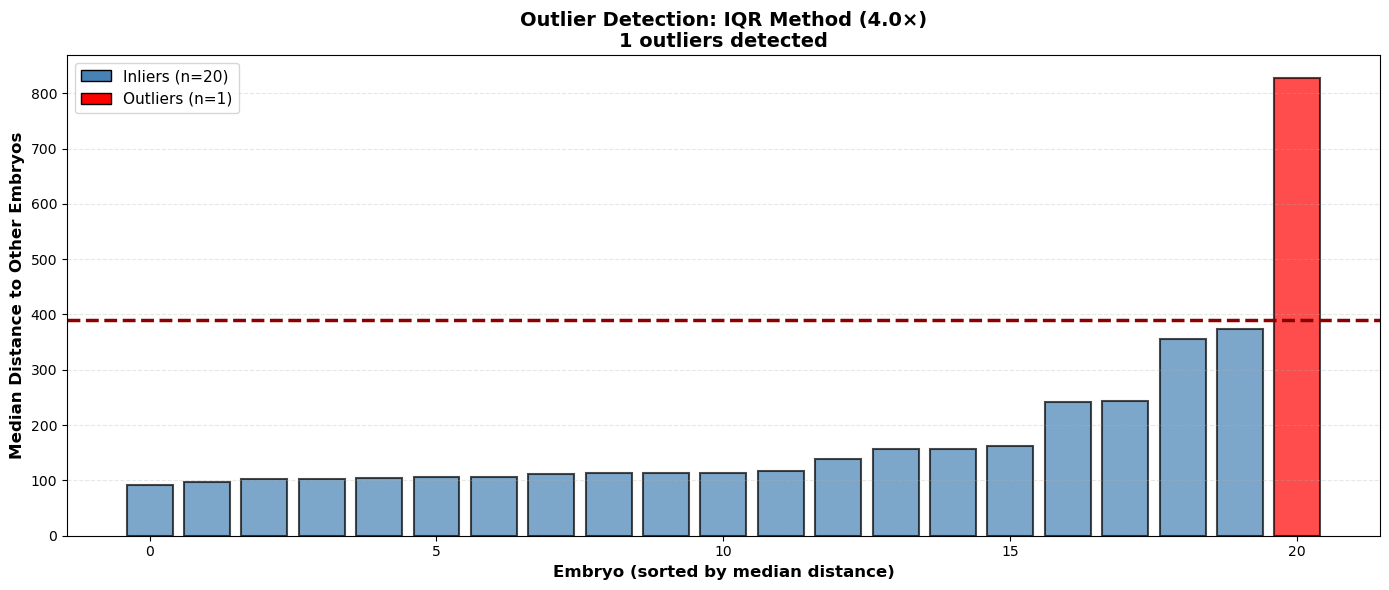

In [12]:


from typing import List, Optional, Tuple

def plot_outlier_detection(
    median_distances: np.ndarray,
    embryo_ids: List[str],
    outlier_ids: List[str],
    threshold: float,
    method: str = 'iqr',
    multiplier: Optional[float] = None,
    figsize: Tuple[int, int] = (14, 6),
    title: Optional[str] = None,
) -> plt.Figure:
    """Plot median distance bar chart with outlier detection threshold.
    
    Visualizes the distribution of median distances across embryos, highlighting
    outliers detected by the specified method.
    
    Args:
        median_distances: Array of median distances for each embryo
        embryo_ids: List of embryo IDs (same order as median_distances)
        outlier_ids: List of embryo IDs identified as outliers
        threshold: Detection threshold value
        method: Detection method used ('iqr', 'percentile', 'mad', 'median_distance')
        multiplier: Method-specific multiplier (e.g., IQR multiplier)
        figsize: Figure size (width, height)
        title: Custom title (auto-generated if None)
        
    Returns:
        Matplotlib figure
        
    Example:
        >>> median_dists = np.array([2.1, 2.3, 5.8, 2.0, 2.4])
        >>> embryo_ids = ['e1', 'e2', 'e3', 'e4', 'e5']
        >>> outliers = ['e3']
        >>> fig = plot_outlier_detection(
        ...     median_dists, embryo_ids, outliers,
        ...     threshold=4.5, method='iqr', multiplier=4.0
        ... )
    """
    from matplotlib.patches import Patch
    
    # Sort by median distance
    sorted_idx = np.argsort(median_distances)
    sorted_dists = median_distances[sorted_idx]
    sorted_embryo_ids = [embryo_ids[i] for i in sorted_idx]
    
    # Create outlier mask for sorted data
    outlier_mask = np.array([eid in outlier_ids for eid in sorted_embryo_ids])
    n_outliers = len(outlier_ids)
    n_inliers = len(embryo_ids) - n_outliers
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot bars
    colors = ['red' if is_outlier else 'steelblue' for is_outlier in outlier_mask]
    ax.bar(range(len(sorted_dists)), sorted_dists, color=colors, 
           edgecolor='black', alpha=0.7, linewidth=1.5)
    
    # Threshold line
    threshold_label = f'{method.upper()} Threshold = {threshold:.2f}'
    if multiplier is not None and method == 'iqr':
        threshold_label = f'IQR Threshold ({multiplier}×) = {threshold:.2f}'
    ax.axhline(threshold, color='darkred', linestyle='--', 
               linewidth=2.5, label=threshold_label)
    
    # Labels and formatting
    ax.set_xlabel('Embryo (sorted by median distance)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Median Distance to Other Embryos', fontsize=12, fontweight='bold')
    
    # Auto-generate title if not provided
    if title is None:
        method_name = method.upper()
        if method == 'iqr' and multiplier is not None:
            method_name = f'IQR Method ({multiplier}×)'
        title = f'Outlier Detection: {method_name}\n{n_outliers} outliers detected'
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Color legend
    legend_elements = [
        Patch(facecolor='steelblue', edgecolor='black', label=f'Inliers (n={n_inliers})'),
        Patch(facecolor='red', edgecolor='black', label=f'Outliers (n={n_outliers})')
    ]
    ax.legend(handles=legend_elements, fontsize=11, loc='upper left')
    
    plt.tight_layout()
    
    return fig

# Use the function
fig = plot_outlier_detection(
    median_distances=median_distances,
    embryo_ids=embryo_ids,
    outlier_ids=outlier_ids_iqr,
    threshold=outlier_info_iqr['threshold'],
    method='iqr',
    multiplier=4.0,
    figsize=(14, 6)
)
plt.show()

In [13]:
# ============================================================================
# OPTION 2: Individual Functions (More Control) - Uncomment to use
# ============================================================================

# Import additional functions if not already imported
from src.analyze.trajectory_analysis import (
    plot_dendrogram,
    plot_dendrogram_with_categories,
)

# # Plot basic dendrogram
# fig_basic, dendro_info = plot_dendrogram(
#     D_for_clustering,
#     embryo_ids_for_clustering,
#     k_highlight=[2, 3, 4, 5],
#     linkage_method='average',
#     title='MD-DTW Hierarchical Clustering',
#     figsize=(16, 8),
#     verbose=True
# )
# plt.show()

# # Plot dendrogram with categories
# fig_cat, dendro_cat_info = plot_dendrogram_with_categories(
#     D_for_clustering,
#     embryo_ids_for_clustering,
#     category_df=category_df,
#     category_cols=['pair', 'genotype'],  # Set to None to turn off category bars
#     k_highlight=[2, 3, 4],
#     linkage_method='average',
#     title='MD-DTW Clustering with Categories',
#     figsize=(16, 10),
#     spacer_height=0.7,
#     verbose=True
# )
# plt.show()

# # Access cluster assignments from dendro_info
# print("\n✓ Dendrograms generated (Option 2: Individual functions)")
# print(f"  Available K values: {list(dendro_info['cluster_assignments'].keys())}")
# for k, labels in dendro_info['cluster_assignments'].items():
#     unique, counts = np.unique(labels, return_counts=True)
#     print(f"  k={k}: {dict(zip(unique, counts))}")

print("\n💡 Tip: Both Option 1 and Option 2 give you the same results!")
print("   Option 1 (generate_dendrograms) is just a convenience wrapper")
print("   Option 2 (individual functions) gives more fine-grained control")


💡 Tip: Both Option 1 and Option 2 give you the same results!
   Option 1 (generate_dendrograms) is just a convenience wrapper
   Option 2 (individual functions) gives more fine-grained control


## Step 5b: Extract Cluster Assignments

Add cluster assignments to your DataFrame using either:
- **Option 1:** Use `add_cluster_column()` helper (one line, handles missing embryos)
- **Option 2:** Manual mapping with dict (more explicit, gives you control)

Both are shown below - pick whichever you prefer!

In [ ]:
# Choose K based on dendrogram inspection
k_selected = 3  # Change based on your dendrogram

# ============================================================================
# OPTION 1: Use add_cluster_column() helper (Recommended)
# ============================================================================
df_with_clusters = add_cluster_column(
    df_filtered,
    dendro_info=dendro_info,  # Pass the full info dict from generate_dendrograms()
    k=k_selected,
    column_name='md_dtw_cluster'
)

# ============================================================================
# OPTION 2: Manual mapping (Alternative - uncomment to use)
# ============================================================================
# # If using individual functions, extract cluster assignments from dendro_info
# cluster_labels = dendro_info['cluster_labels'][k_selected]
# cluster_lookup = dict(zip(embryo_ids_for_clustering, cluster_labels))
# 
# # Add to DataFrame
# df_with_clusters = df_filtered.copy()
# df_with_clusters['md_dtw_cluster'] = df_with_clusters['embryo_id'].map(cluster_lookup)

print(f"✓ Cluster assignments added for k={k_selected}")
print(f"  Column name: 'md_dtw_cluster'")

# Check cluster distribution
print(f"\nCluster distribution:")
cluster_summary = df_with_clusters.groupby('md_dtw_cluster')['embryo_id'].nunique()
print(cluster_summary)

# Check genotype distribution per cluster
print(f"\nGenotype distribution per cluster:")
genotype_by_cluster = df_with_clusters.groupby(['md_dtw_cluster', 'genotype'])['embryo_id'].nunique().unstack(fill_value=0)
print(genotype_by_cluster)

✓ Cluster assignments added for k=3
  Column name: 'md_dtw_cluster'

Cluster distribution:
md_dtw_cluster
0.0     2
1.0    17
2.0     1
Name: embryo_id, dtype: int64

Genotype distribution per cluster:
genotype        b9d2_heterozygous  b9d2_homozygous  b9d2_unknown  \
md_dtw_cluster                                                     
0.0                             0                1             1   
1.0                            11                2             1   
2.0                             0                1             0   

genotype        b9d2_wildtype  
md_dtw_cluster                 
0.0                         0  
1.0                         3  
2.0                         0  


## Step 5c: Plot Trajectories by Cluster

Visualize the actual trajectories colored by cluster assignment.

**New color logic (FIXED):**
- When `col_by='cluster'` or `color_by='cluster'`: Uses simple color palette (perfect for cluster numbers)
- When `col_by='genotype'` or `color_by='genotype'`: Uses custom genotype colors
- No more incorrect color mapping!

**Useful for:**
- Understanding what phenotypic differences define each cluster
- Validating cluster assignments match biology
- Generating publication-quality figures

In [ ]:
# Plot multimetric trajectories (metrics in rows, clusters in columns)
# Color logic: cluster numbers use simple palette, genotypes use custom colors
fig_trajectories = plot_multimetric_trajectories(
    df_with_clusters,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='md_dtw_cluster',  # Separate plot per cluster
    color_by_grouping='md_dtw_cluster',  # NEW API: groups AND colors by cluster
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title='Trajectories by MD-DTW Cluster',
    x_label='Time (hpf)',
    backend='matplotlib',
    bin_width=2.0,
)

plt.tight_layout()
plt.show()

# Optional: Color by genotype instead to validate clusters separate genotypes
fig_by_genotype = plot_multimetric_trajectories(
    df_with_clusters,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='md_dtw_cluster',
    color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title='Trajectories by Cluster, Grouped by Genotype',
    x_label='Time (hpf)',
    backend='matplotlib',
    bin_width=2.0,
)

plt.tight_layout()
plt.show()

# Optional: Save figures
# fig_trajectories.savefig('output/md_dtw_trajectories_by_cluster.png', dpi=300, bbox_inches='tight')
# fig_by_genotype.savefig('output/md_dtw_trajectories_by_genotype.png', dpi=300, bbox_inches='tight')

In [ ]:
# Loop through multiple K values to compare clustering results
for k_selected in [3,4,5,]: 
    df_with_clusters = add_cluster_column(
        df_filtered,
        dendro_info=dendro_info,
        k=k_selected,
        column_name='md_dtw_cluster'
    )

    # Plot colored by cluster
    fig_trajectories = plot_multimetric_trajectories(
        df_with_clusters,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='md_dtw_cluster',
        color_by_grouping='md_dtw_cluster',  # NEW API: groups AND colors by cluster
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title=f'Trajectories by MD-DTW Cluster (k={k_selected})',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )

    plt.tight_layout()
    plt.show()

    # Plot colored by genotype
    fig_by_genotype = plot_multimetric_trajectories(
        df_with_clusters,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='md_dtw_cluster',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title=f'Trajectories by Cluster (k={k_selected}), Grouped by Genotype',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )

### b9d2_pair_5 clustering ononly curvutrue data. not length 

In [ ]:
# Define which metrics to use - curvature only analysis
metrics = ['baseline_deviation_normalized']

# Filter by pair
df_b9d2_pair_5 = df[df['pair'].isin(['b9d2_pair_5', ])].copy()
df_filtered = df_b9d2_pair_5.copy()

print(f"✓ Filtered data: {df_filtered['embryo_id'].nunique()} embryos")

# Prepare multivariate array
X, embryo_ids, time_grid = prepare_multivariate_array(
    df_filtered,
    metrics=metrics,
    time_col='predicted_stage_hpf',
    embryo_id_col='embryo_id',
    normalize=True,
    verbose=True
)

print(f"\n✓ Array prepared:")
print(f"  Shape: {X.shape} (embryos × timepoints × metrics)")

# Compute MD-DTW distance matrix
D = compute_md_dtw_distance_matrix(
    X,
    sakoe_chiba_radius=3,
    verbose=True
)

print(f"\n✓ Distance matrix computed: {D.shape}")

# Outlier detection
outlier_ids_iqr, inlier_ids_iqr, outlier_info_iqr = identify_outliers(
    D,
    embryo_ids,
    method='iqr',
    threshold=4.0,
    verbose=True
)

if len(outlier_ids_iqr) > 0:
    print(f"  Outlier embryos: {outlier_ids_iqr}")
    
    median_distances = np.zeros(len(embryo_ids))
    for i in range(len(embryo_ids)):
        dists_to_others = np.concatenate([D[i, :i], D[i, i+1:]])
        median_distances[i] = np.median(dists_to_others)

    fig = plot_outlier_detection(
        median_distances=median_distances,
        embryo_ids=embryo_ids,
        outlier_ids=outlier_ids_iqr,
        threshold=outlier_info_iqr['threshold'],
        method='iqr',
        multiplier=4.0,
        figsize=(14, 6)
    )

    D_clean, embryo_ids_clean, outlier_info = remove_outliers_from_distance_matrix(
        D,
        embryo_ids,
        outlier_detection_method='iqr',
        outlier_threshold=4.0,
        verbose=True
    )

    D_for_clustering = D_clean
    embryo_ids_for_clustering = embryo_ids_clean
else:
    D_for_clustering = D
    embryo_ids_for_clustering = embryo_ids

print(f"\n✓ IQR outlier detection complete")

# Prepare category DataFrame
category_df = df_filtered[['embryo_id', 'pair', 'genotype']].drop_duplicates().reset_index(drop=True)
print(f"✓ Category DataFrame prepared: {len(category_df)} embryos")

# Generate dendrogram
fig_cat, dendro_info = plot_dendrogram_with_categories(
    D_for_clustering,
    embryo_ids_for_clustering,
    category_df=category_df,
    category_cols=['pair', 'genotype'],
    k_highlight=[2, 3, 4, 5],
    linkage_method='average',
    title='MD-DTW Clustering with Categories (Curvature Only)',
    figsize=(16, 10),
    spacer_height=0.7,
    verbose=True
)
plt.show()

# Loop through K values
for k_selected in [3,4,5,]: 
    df_with_clusters = add_cluster_column(
        df_filtered,
        dendro_info=dendro_info,
        k=k_selected,
        column_name='md_dtw_cluster'
    )

    # Plot by cluster
    fig_trajectories = plot_multimetric_trajectories(
        df_with_clusters,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='md_dtw_cluster',
        color_by_grouping='md_dtw_cluster',  # NEW API
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title=f'Trajectories by MD-DTW Cluster (k={k_selected}, Curvature Only)',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )
    plt.tight_layout()
    plt.show()

    # Plot by genotype
    fig_by_genotype = plot_multimetric_trajectories(
        df_with_clusters,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='md_dtw_cluster',
        color_by_grouping='genotype',  # NEW API
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title=f'Trajectories by Cluster (k={k_selected}), Grouped by Genotype',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )

In [ ]:
import importlib                                                                                  
import sys                                                                                        
sys.modules.pop('src.analyze.trajectory_analysis.dendrogram', None)                               
sys.modules.pop('src.analyze.trajectory_analysis', None)                                          



import importlib
import src.analyze.trajectory_analysis as ta
import src.analyze.trajectory_analysis.dendrogram as dg

importlib.reload(dg)
importlib.reload(ta)
    # Optional: Color by genotype instead to validate clusters separate genotypes
    
fig_by_genotype = plot_multimetric_trajectories(
        df,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='pair',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title='Trajectories by Pair, Grouped by Genotype',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )